In [10]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Model

print(tf.__version__)


warnings.filterwarnings("ignore", category=UserWarning) 

training_file = '../training_processed.csv'
testing_file = '../智能制造赛道测试集/test/testing.csv'

2.9.2


## 01 - loading and preprocess data

In [2]:
# load training & testing file
training = pd.read_csv(training_file, low_memory=False)
testing = pd.read_csv(testing_file, low_memory=False)

numerical_features = [
                      # 'oxygen_set_value', # '氧量设定值'
                      # 'primary_air_volume', # '一次风量'
                      # 'grate_manual_command',  #  '炉排手动指令'
                      'main_steam_flow_set_value', # '主蒸汽流量设定值'
                      # 'ejector_manual_command', #  '推料器手动指令'
                      # 'ejector_automatic_command', # '推料器自动指令'
                      # 'nox_content', # NOx含量
                      # 'grate_actual_operation_command', # 炉排实际运行指令
                      # 'secondary_air_control_door', # 二次风调门
                      # 'hcl_content', # HCL含量
                      'secondary_air_volume', # 二次风量
                      'water_flow', # 给水流量
                      # 'so2_content', # SO2含量
                      # 'drum_water_level', # 汽包水位
                      # 'induced_fan_speed', # 引风机转速
                      # 'co_content', # CO含量
                      # 'primary_damper' # 一次风调门
                      ] 

categorical_features = ['ejector_automatic_switching_signal', # '推料器自动投退信号'
                        'grate_automatic_switching_signal', # '炉排自动投退信号'
                        'pusher_on_or_off', # 推料器启停
                        'grate_on_or_off'] # 炉排启停

label = ['main_steam_flow']

## 02 feature engineering

In [3]:
# append traning and testing dataframe (apply feature engineering together, avoid training and serving skew)
# adding label column for testing dataset before merge
testing['main_steam_flow'] = 0
# concat 2 dataframe
data_all = pd.concat([training, testing], axis=0)
# sort
data_all.sort_values(by=['datetime'], ascending=True, inplace=True)

In [4]:
# one-encoding
onehot_encoding = pd.get_dummies(data_all[categorical_features].astype(str))
# concat back to previous dataframe
data_all = pd.concat([data_all, onehot_encoding], axis=1)
# drop previous column
data_all = data_all.drop(columns=categorical_features)
# normalization
scaler = MinMaxScaler()
# fit scaler
scaler.fit(data_all[numerical_features + label])
# print log
print(f"Scaler max value is {scaler.data_max_}, min value is {scaler.data_min_}")
# transform data
data_all[numerical_features + label] = scaler.transform(data_all[numerical_features + label])

Scaler max value is [   70.0361 35791.0586   100.2972    79.2595], min value is [42.6552  0.     46.8703  0.    ]


In [5]:
# split data_all back to training and testing
training = data_all.iloc[:-1800]
testing = data_all.iloc[-1800:]

training.head(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
0,2021-12-20 00:00:00,5.5,72919.6563,43.9083,0.633463,53.9083,53.9094,57.4444,43.9078,20.4653,...,75.5532,0.685132,0,1,0,1,0,1,0,1


In [6]:
training.tail(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
257399,2021-12-22 23:29:59,25.0,72773.5469,50.0,0.633463,40.0,70.0,111.5555,50.0,49.4558,...,65.5602,0.732084,1,0,1,0,1,0,1,0


In [7]:
testing.head(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
0,2021-12-22 23:30:00,25.0,72881.2344,50.0,0.633463,40.0,70.0,111.4074,50.0,49.4537,...,65.537,0.0,1,0,1,0,1,0,1,0


In [8]:
testing.tail(1)

,datetime,oxygen_set_value,primary_air_volume,grate_manual_command,main_steam_flow_set_value,ejector_manual_command,ejector_automatic_command,nox_content,grate_actual_operation_command,secondary_air_control_door,...,primary_damper,main_steam_flow,ejector_automatic_switching_signal_False,ejector_automatic_switching_signal_True,grate_automatic_switching_signal_False,grate_automatic_switching_signal_True,pusher_on_or_off_False,pusher_on_or_off_True,grate_on_or_off_False,grate_on_or_off_True
1799,2021-12-22 23:59:59,25.0,78989.5,50.0,0.633463,100.0,100.0,72.0556,50.0,20.6852,...,70.5995,0.0,0,1,0,1,1,0,1,0


## 02 - modeling - rnn + nn

### 2.1 train LSTM model

#### Define a window function to slice data

In [133]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in  enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    
    def make_dataset(self, data, is_shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=is_shuffle,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def val2(self):
        return self.make_dataset(self.val_df, False) # dont shuffle

In [134]:
# retrieve features and labels
x = training[numerical_features + label]

# split training data into train and validation (latest 1800 records for validation, remaining for training)
val_num = 7200
x_train = x[:-val_num]
x_val = x[-val_num:]

input_width = 6 # how many time steps are using
label_width = 1 # how many labels are predicted one at time
shift = 0 # offset between input feature and label

# init window generator
w_lstm = WindowGenerator(input_width, 
                         label_width,
                         shift,
                         train_df=x_train,
                         val_df=x_val,
                         label_columns=label)

w_lstm

Total window size: 6
Input indices: [0 1 2 3 4 5]
Label indices: [5]
Label column name(s): ['main_steam_flow']

In [135]:
for example_inputs, example_labels in w_lstm.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
    print(example_inputs[0])
    print(example_labels[0])

Inputs shape (batch, time, features): (32, 6, 4)
Labels shape (batch, time, features): (32, 1, 1)
tf.Tensor(
[[0.6334635  0.09371341 0.61792654 0.7557731 ]
 [0.6334635  0.09371341 0.6177525  0.7581337 ]
 [0.6334635  0.09371341 0.6175335  0.7612084 ]
 [0.6334635  0.08381981 0.6173239  0.7564998 ]
 [0.6334635  0.08381981 0.6169514  0.7562576 ]
 [0.6334635  0.08381981 0.6169252  0.75804037]], shape=(6, 4), dtype=float32)
tf.Tensor([[0.75804037]], shape=(1, 1), dtype=float32)


In [136]:
example_inputs[0, :5, :]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.6334635 , 0.09371341, 0.61792654, 0.7557731 ],
       [0.6334635 , 0.09371341, 0.6177525 , 0.7581337 ],
       [0.6334635 , 0.09371341, 0.6175335 , 0.7612084 ],
       [0.6334635 , 0.08381981, 0.6173239 , 0.7564998 ],
       [0.6334635 , 0.08381981, 0.6169514 , 0.7562576 ]], dtype=float32)>

In [137]:
example_inputs[0, -1, :3]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.6334635 , 0.08381981, 0.6169252 ], dtype=float32)>

### Define a customized model

In [138]:
# define hyperparameter
MAX_EPOCHS = 200
patience = 3
lr = 1e-3
batch_size = 32

# using functional API to build model 
inputs = keras.Input(shape=(6, 4))
x1 = layers.LSTM(32)(inputs[:, :5, :])
x2 = layers.Dense(32, activation='relu')(inputs[:, -1, :3])
x = layers.Concatenate(axis=-1)([x1, x2])
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])


# define early stoping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 6, 4)]       0           []                               
                                                                                                  
 tf.__operators__.getitem_26 (S  (None, 5, 4)        0           ['input_15[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_27 (S  (None, 3)           0           ['input_15[0][0]']               
 licingOpLambda)                                                                                  
                                                                                            

In [139]:
# test forward pass
random_input = tf.random.normal([32, 6, 4])
random_output = model(random_input)
random_output

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.08996148],
       [ 0.08172622],
       [ 0.18886319],
       [-0.04442333],
       [ 0.22568859],
       [ 0.05707255],
       [ 0.18049389],
       [-0.03030537],
       [ 0.37659064],
       [ 0.18316042],
       [-0.02566229],
       [ 0.24412686],
       [-0.10305707],
       [-0.04422274],
       [ 0.25948104],
       [ 0.04769907],
       [ 0.5043645 ],
       [ 0.24154499],
       [ 0.06469423],
       [ 0.3785589 ],
       [ 0.00943656],
       [ 0.23723587],
       [ 0.27848828],
       [ 0.05787132],
       [ 0.00113784],
       [ 0.05818079],
       [ 0.08989094],
       [ 0.0235869 ],
       [ 0.06799191],
       [ 0.27213582],
       [ 0.28600216],
       [ 0.19304799]], dtype=float32)>

In [140]:
history = model.fit(w_lstm.train,
                    epochs=MAX_EPOCHS,
                    validation_data=w_lstm.val,
                    callbacks=[early_stopping])

Epoch 1/200
7819/7819 [==============================] - 22s 3ms/step - loss: 6.7547e-04 - mean_absolute_error: 0.0051 - val_loss: 9.6502e-06 - val_mean_absolute_error: 0.0022
Epoch 2/200
7819/7819 [==============================] - 20s 3ms/step - loss: 9.3754e-06 - mean_absolute_error: 0.0023 - val_loss: 3.4328e-05 - val_mean_absolute_error: 0.0053
Epoch 3/200
7819/7819 [==============================] - 21s 3ms/step - loss: 8.2850e-06 - mean_absolute_error: 0.0022 - val_loss: 9.0847e-06 - val_mean_absolute_error: 0.0023
Epoch 4/200
7819/7819 [==============================] - 21s 3ms/step - loss: 7.4702e-06 - mean_absolute_error: 0.0021 - val_loss: 8.1567e-06 - val_mean_absolute_error: 0.0020
Epoch 5/200
7819/7819 [==============================] - 20s 3ms/step - loss: 7.0290e-06 - mean_absolute_error: 0.0020 - val_loss: 6.6261e-06 - val_mean_absolute_error: 0.0019
Epoch 6/200
7819/7819 [==============================] - 21s 3ms/step - loss: 6.6013e-06 - mean_absolute_error: 0.0020 -

### Evaluate prediction

In [143]:
%%time
model.evaluate(w_lstm.val)

225/225 [==============================] - 0s 1ms/step - loss: 5.4492e-06 - mean_absolute_error: 0.0018
CPU times: user 1.37 s, sys: 477 ms, total: 1.85 s
Wall time: 403 ms


[5.449188847705955e-06, 0.0018109532538801432]

In [144]:
%%time
model.evaluate(w_lstm.val2)

225/225 [==============================] - 0s 2ms/step - loss: 5.4492e-06 - mean_absolute_error: 0.0018
CPU times: user 1.47 s, sys: 520 ms, total: 1.99 s
Wall time: 429 ms


[5.4491893024533056e-06, 0.0018109525553882122]

In [145]:
predictions = model.predict(w_lstm.val2)

225/225 [==============================] - 1s 1ms/step


In [146]:
predictions.shape

(7195, 1)

In [150]:
predictions.shape

(7195, 1)

In [151]:
true_pred = np.concatenate(([0, 0, 0, 0, 0], predictions.reshape(7195)), axis=0)
len(true_pred)

7200

In [152]:
x_val['prediction'] = true_pred

In [153]:
# inverse to previous value
x_val_inversed = scaler.inverse_transform(x_val[['main_steam_flow_set_value', 'secondary_air_volume', 'water_flow', 'main_steam_flow']])
x_val_inversed_prediction = scaler.inverse_transform(x_val[['main_steam_flow_set_value', 'secondary_air_volume', 'water_flow', 'prediction']])

In [159]:
x_val_inversed.shape

(7200, 4)

<AxesSubplot:>

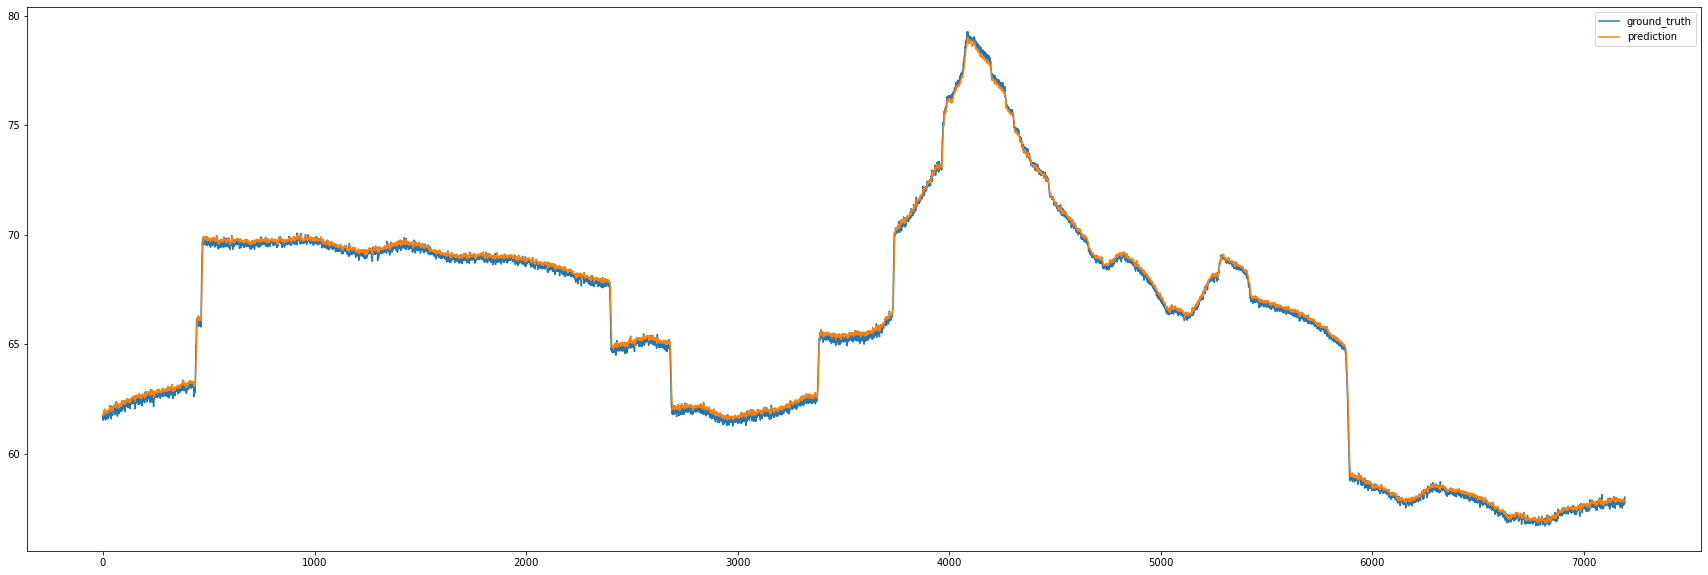

In [160]:
# append predictions with ground truth
val_df = pd.DataFrame(data={#'datetime': training.iloc[-val_num:]['datetime'],
                            'ground_truth': x_val_inversed[6:,3],
                            'prediction': x_val_inversed_prediction[6:,3]
                           })

# val_df.index = pd.to_datetime(val_df['datetime'], format='%Y-%m-%d %X')

# plot ground truth vs predictions
val_df[['ground_truth', 'prediction']].plot.line(figsize=(30, 10))

<AxesSubplot:>

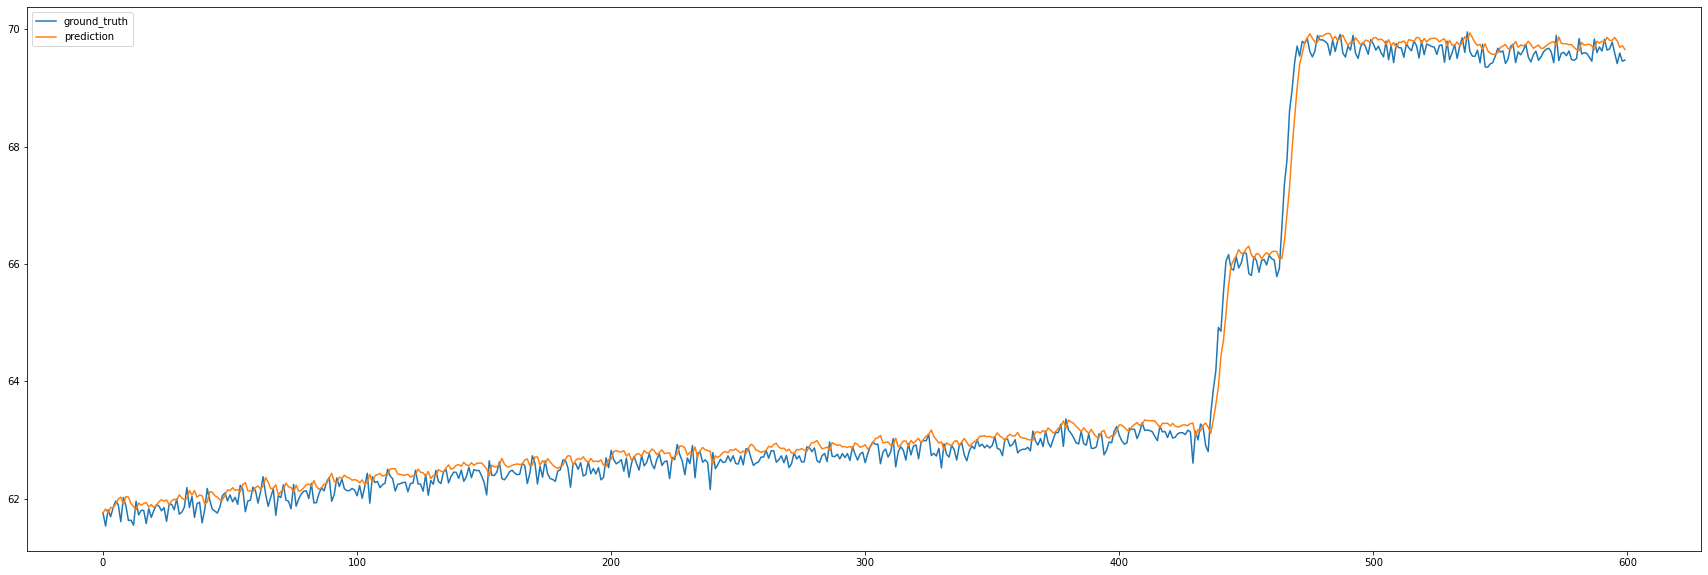

In [210]:
# plot ground truth vs predictions
val_df[['ground_truth', 'prediction']].head(600).plot.line(figsize=(30, 10))

<AxesSubplot:>

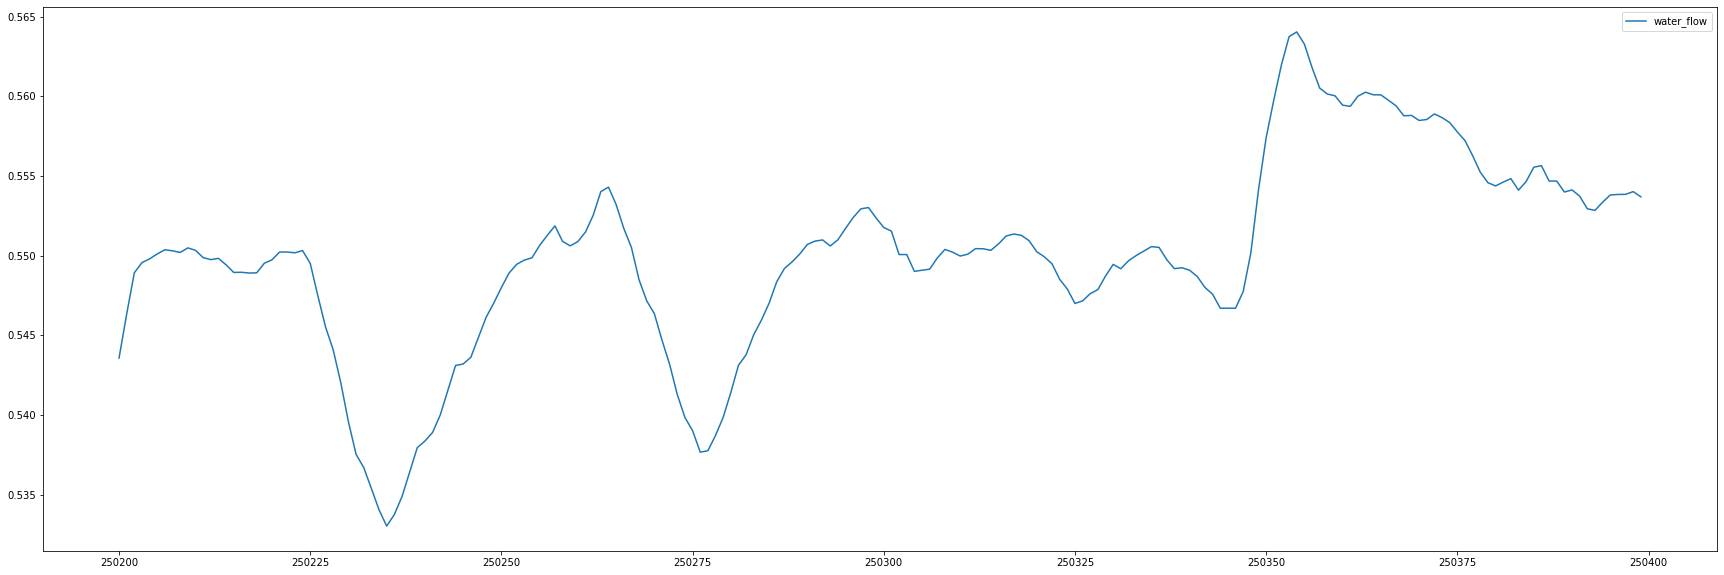

In [169]:
# plot ground truth vs predictions
x_val[['water_flow']].head(200).plot.line(figsize=(30, 10))

In [205]:
# retrieve last 5 records from validation and append to test
x_submission = pd.concat([x_val[-5:], testing[numerical_features + label]], axis=0)
x_submission = x_submission[numerical_features + label]
x_submission.head(10)

,main_steam_flow_set_value,secondary_air_volume,water_flow,main_steam_flow
257395,0.633463,0.517832,0.407222,0.729007
257396,0.633463,0.518397,0.406939,0.729234
257397,0.633463,0.521774,0.406913,0.728869
257398,0.633463,0.520088,0.407061,0.728502
257399,0.633463,0.518397,0.407072,0.732084
0,0.633463,0.518397,0.407695,0.000000
1,0.633463,0.516133,0.407922,0.000000
2,0.633463,0.518397,0.407475,0.000000
3,0.633463,0.518397,0.407130,0.000000
4,0.633463,0.520088,0.406939,0.000000


In [206]:
x_submission.tail(10)

,main_steam_flow_set_value,secondary_air_volume,water_flow,main_steam_flow
1790,0.633463,0.181072,0.406065,0.0
1791,0.633463,0.185858,0.405970,0.0
1792,0.633463,0.185858,0.405578,0.0
1793,0.633463,0.181072,0.405595,0.0
1794,0.633463,0.185858,0.405303,0.0
1795,0.633463,0.174485,0.404899,0.0
1796,0.633463,0.174485,0.404145,0.0
1797,0.633463,0.174485,0.403922,0.0
1798,0.633463,0.169377,0.404558,0.0
1799,0.633463,0.156813,0.406213,0.0


### rolling prediction

In [207]:
# calc number of iteration
num_iteration = x_submission.shape[0] - input_width
# define start index and end index
s_idx, e_idx = 0, input_width

for i in range(0, num_iteration+1):
    # retrieve input features
    input_features = x_submission.iloc[s_idx:e_idx]
    # make prediction
    pred = model.predict(input_features.values.reshape(1, input_width, 4))
    # update prediction in dataframe as next step feature input
    x_submission.iloc[e_idx - 1]['main_steam_flow'] = pred[0][0]
    # increase start and end idx
    s_idx += 1
    e_idx += 1
    
    break

1/1 [==============================] - 0s 15ms/step


In [208]:
x_submission.head(10)

,main_steam_flow_set_value,secondary_air_volume,water_flow,main_steam_flow
257395,0.633463,0.517832,0.407222,0.729007
257396,0.633463,0.518397,0.406939,0.729234
257397,0.633463,0.521774,0.406913,0.728869
257398,0.633463,0.520088,0.407061,0.728502
257399,0.633463,0.518397,0.407072,0.732084
0,0.633463,0.518397,0.407695,0.731694
1,0.633463,0.516133,0.407922,0.000000
2,0.633463,0.518397,0.407475,0.000000
3,0.633463,0.518397,0.407130,0.000000
4,0.633463,0.520088,0.406939,0.000000


In [199]:
x_submission.tail(10)

,main_steam_flow_set_value,secondary_air_volume,water_flow,main_steam_flow
1790,0.633463,0.181072,0.406065,0.952417
1791,0.633463,0.185858,0.405970,0.952541
1792,0.633463,0.185858,0.405578,0.952444
1793,0.633463,0.181072,0.405595,0.952411
1794,0.633463,0.185858,0.405303,0.952541
1795,0.633463,0.174485,0.404899,0.952279
1796,0.633463,0.174485,0.404145,0.952372
1797,0.633463,0.174485,0.403922,0.952395
1798,0.633463,0.169377,0.404558,0.952442
1799,0.633463,0.156813,0.406213,0.952505


In [200]:
# inverse to previous value
x_submission_inversed = scaler.inverse_transform(x_submission)
x_submission_inversed

array([[   60.        , 18533.752     ,    68.6269    ,    57.7807    ],
       [   60.        , 18553.9766    ,    68.6118    ,    57.7987    ],
       [   60.        , 18674.8496    ,    68.6104    ,    57.7698    ],
       ...,
       [   60.        ,  6244.998     ,    68.4506    ,    75.48635796],
       [   60.        ,  6062.1777    ,    68.4846    ,    75.49010901],
       [   60.        ,  5612.4863    ,    68.573     ,    75.49508835]])

In [201]:
x_submission_inversed[5:,2]

array([68.6522, 68.6643, 68.6404, ..., 68.4506, 68.4846, 68.573 ])

In [202]:
# generate submission file
submission_file = pd.DataFrame(data={'ID':[i for i in range(1, 1801)], 
                                     'Time':testing['datetime'].values, 
                                     'Steam_flow':x_submission_inversed[5:,3],
                                     'Water_flow':x_submission_inversed[5:,2]})
submission_file.head()

,ID,Time,Steam_flow,Water_flow
0,1,2021-12-22 23:30:00,57.993666,68.6522
1,2,2021-12-22 23:30:01,58.033931,68.6643
2,3,2021-12-22 23:30:02,58.080946,68.6404
3,4,2021-12-22 23:30:03,58.132677,68.6220
4,5,2021-12-22 23:30:04,58.196723,68.6118


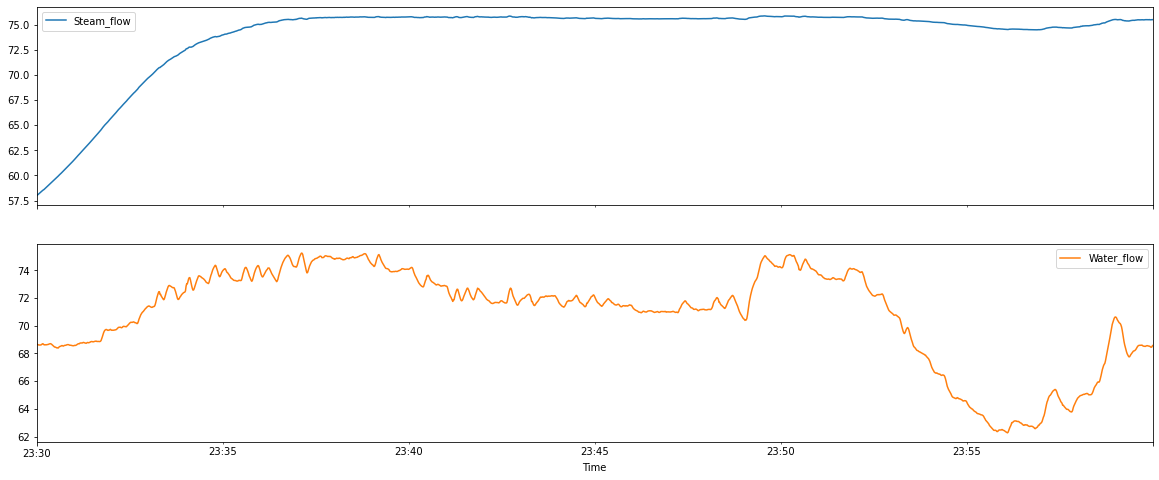

In [203]:
# plot predictions
date_time = pd.to_datetime(submission_file['Time'], format='%Y-%m-%d %H:%M:%S')
plot_cols = ['Steam_flow', 'Water_flow']
plot_features = submission_file[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(20, 8))

In [204]:
submission_file.head()

,ID,Time,Steam_flow,Water_flow
0,1,2021-12-22 23:30:00,57.993666,68.6522
1,2,2021-12-22 23:30:01,58.033931,68.6643
2,3,2021-12-22 23:30:02,58.080946,68.6404
3,4,2021-12-22 23:30:03,58.132677,68.6220
4,5,2021-12-22 23:30:04,58.196723,68.6118


In [192]:
# define output columns
output_columns = ['ID','Time','Steam_flow']

# write to local disk
submission_file[output_columns].to_csv('../submission_c_rnn.csv', index=False)

In [193]:
submission_file[output_columns].head()

,ID,Time,Steam_flow
0,1,2021-12-22 23:30:00,57.993666
1,2,2021-12-22 23:30:01,58.033931
2,3,2021-12-22 23:30:02,58.080946
3,4,2021-12-22 23:30:03,58.132677
4,5,2021-12-22 23:30:04,58.196723


In [ ]:
# final test score 4.5